# Animal Image Classification using Bidirectional GRU

**Objective: To create a model that can identify dogs and pandas from images using bidirectional GRUs.**

### Intution behind the idea:

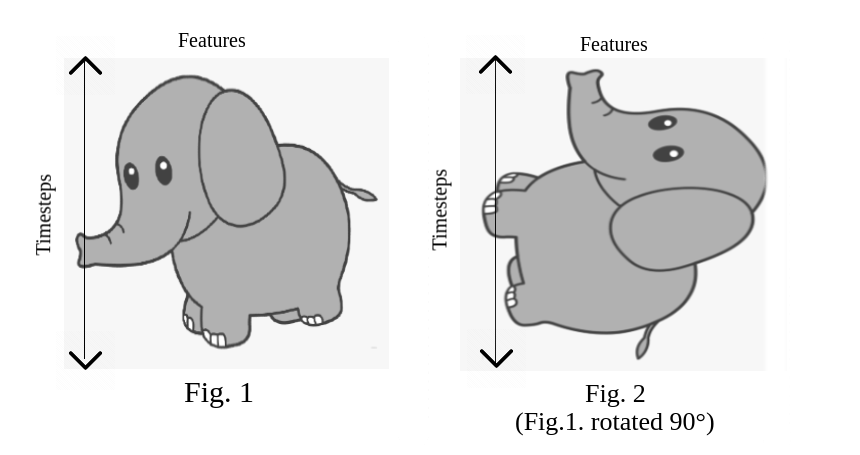

**The idea is to scan the image completely in all four directions:**

**Along height - forward and backward (as in Fig.1.)** <br>
**Along width - forward and backward (as in Fig.2.)**

We'll feed a single channel image to two bidirectional GRU layers. The first BiGRU layer will take the image and scan it along height dimension. The second BiGRU will take a 90° rotated version of the same image and scan it along width dimension.

The shape of the image is 2D, and is similar to the shape of the output from an embedding layer. Hence it can be fed to GRUs or LSTMs.

## Importing Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np

**Creating DataFrame**

In [2]:
df = pd.DataFrame(columns=["path","label"])

path = "../input/animal-image-datasetdog-cat-and-panda/animals/"

for i in os.listdir(path + "dogs"):
    df = df.append({"path":path+"dogs/"+i,"label":"dog"},ignore_index=True)

for i in os.listdir(path + "panda"):
    df = df.append({"path":path+"panda/"+i,"label":"panda"},ignore_index=True)
    
df.head(5)

,path,label
0,../input/animal-image-datasetdog-cat-and-panda...,dog
1,../input/animal-image-datasetdog-cat-and-panda...,dog
2,../input/animal-image-datasetdog-cat-and-panda...,dog
3,../input/animal-image-datasetdog-cat-and-panda...,dog
4,../input/animal-image-datasetdog-cat-and-panda...,dog


**Let's print the shape of an image from df**

In [3]:
plt.imread(df[df['label'] == 'dog'].iloc[0,0]).shape

(439, 500, 3)

**Note that it is an RGB image. We have to convert the RGB channels to a single channel before feeding to LSTMs**

**Images of dogs**

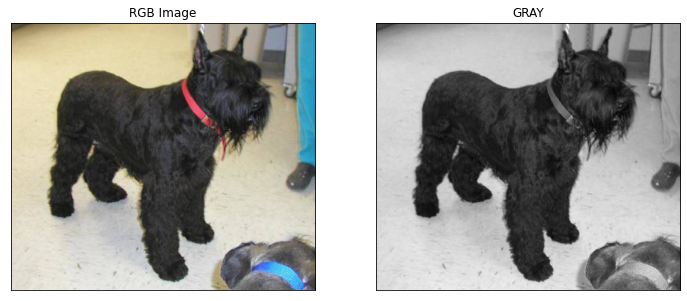

In [4]:
img = plt.imread(df[df['label'] == 'dog'].iloc[0,0])
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,10),subplot_kw=dict(xticks=[],yticks=[]))
ax1.imshow(img)
ax1.set_title("RGB Image")
ax2.imshow(img_gray,cmap="gray")
_=ax2.set_title("GRAY")

**Images of pandas**

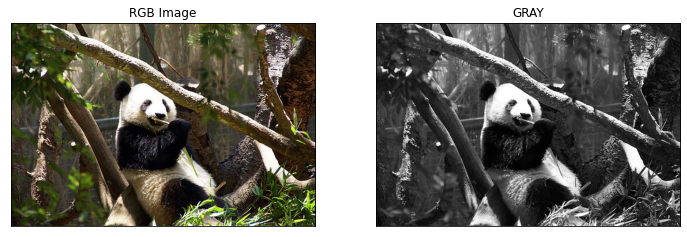

In [5]:
img = plt.imread(df[df['label'] == 'panda'].iloc[2,0])
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,10),subplot_kw=dict(xticks=[],yticks=[]))
ax1.imshow(img)
ax2.imshow(img_gray,cmap="gray")
ax1.set_title("RGB Image")
_=ax2.set_title("GRAY")

## Creating Image Data Generator
**Let's create an Image Data Generator to feed our images to the model**

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
generator = ImageDataGenerator(validation_split=0.2)
train = generator.flow_from_dataframe(df,x_col='path',y_col='label',color_mode="grayscale",target_size=(128,128))

Found 2000 validated image filenames belonging to 2 classes.


### Creating the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Lambda, GRU
from tensorflow.keras.layers import Permute,GlobalMaxPool1D,Concatenate, Dense, BatchNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
input_ = Input(shape=(128,128,1))
lambda_ = Lambda(lambda x: tf.squeeze(x,axis=3))(input_)

lstm_ = Bidirectional(GRU(8,activation='relu',return_sequences=True))(lambda_)

permute_=Permute((2,1),input_shape=(128,128))(lambda_)
lstm_2 = Bidirectional(GRU(8,activation='relu',return_sequences=True))(permute_)


lstm_ = BatchNormalization()(lstm_)
maxpool1 = GlobalMaxPool1D()(lstm_)


lstm_2 = BatchNormalization()(lstm_2)
maxpool2 = GlobalMaxPool1D()(lstm_2)


concat_ = Concatenate(axis=1)([maxpool1,maxpool2])
dense_1 = Dense(20,activation='relu')(concat_)
output_ = Dense(2,activation='softmax')(dense_1)

model = Model(input_,output_)

**Model summary**

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128)     0           input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 128)     0           lambda[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128, 16)      6624        lambda[0][0]                     
______________________________________________________________________________________________

**Visualizing the model architecture**

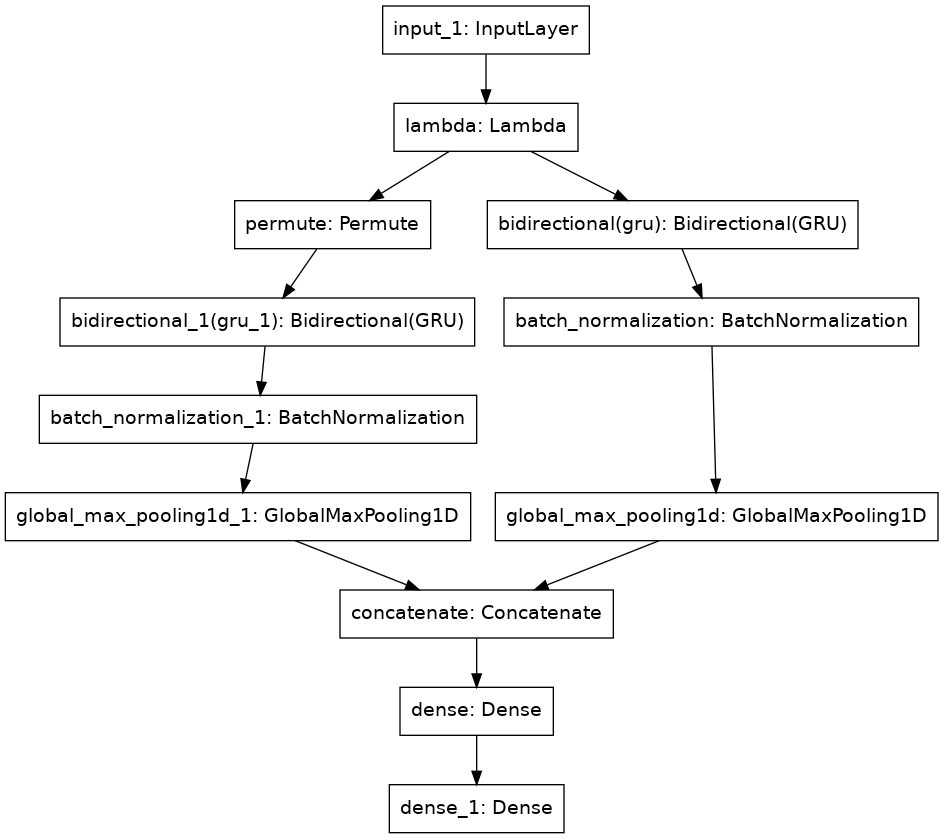

In [11]:
plot_model(model)

**Defining Callbacks**

In [12]:
early = EarlyStopping(patience=4)
reduce_lr = ReduceLROnPlateau(factor=0.1,patience=1)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**Model fitting**

In [13]:
history = model.fit(x=train,epochs=80,callbacks=[early,reduce_lr])

Epoch 1/80
63/63 [==============================] - 26s 334ms/step - loss: 0.9959 - accuracy: 0.6439
Epoch 2/80
63/63 [==============================] - 12s 183ms/step - loss: 0.4632 - accuracy: 0.7888
Epoch 3/80
63/63 [==============================] - 12s 183ms/step - loss: 0.4488 - accuracy: 0.8004
Epoch 4/80
63/63 [==============================] - 12s 184ms/step - loss: 0.4049 - accuracy: 0.8307
Epoch 5/80
63/63 [==============================] - 12s 183ms/step - loss: 0.4105 - accuracy: 0.8187
Epoch 6/80
63/63 [==============================] - 12s 183ms/step - loss: 0.4163 - accuracy: 0.8210
Epoch 7/80
63/63 [==============================] - 12s 185ms/step - loss: 0.3801 - accuracy: 0.8395
Epoch 8/80
63/63 [==============================] - 11s 181ms/step - loss: 0.3757 - accuracy: 0.8374
Epoch 9/80
63/63 [==============================] - 11s 181ms/step - loss: 0.3618 - accuracy: 0.8415
Epoch 10/80
63/63 [==============================] - 12s 186ms/step - loss: 0.3325 - accura

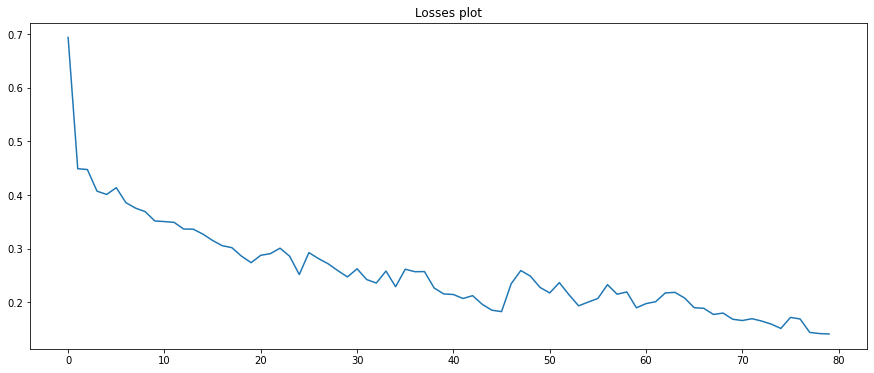

In [14]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
_=plt.title("Losses plot")

In [15]:
print("Accuracy is: ",format(history.history['accuracy'][-1],".2f"))

Accuracy is:  0.94


## Model Prediction

**Defining predict function**

In [16]:
index_class = {v:s for s,v in train.class_indices.items()}
def predict(path):
    a = plt.imread(path)
    a = cv2.resize(a, (128,128),interpolation = cv2.INTER_NEAREST)
    a = cv2.cvtColor(a,cv2.COLOR_BGR2GRAY)
    a = tf.expand_dims(a,axis=-1)
    a = tf.expand_dims(a,axis=0)
    a = np.argmax(model.predict(a))
    return index_class[a]

**Can our model predict Tucker Budzyn?**

It's a dog!


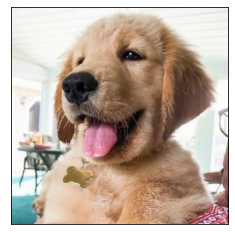

In [17]:
!curl -s https://yt3.ggpht.com/ytc/AAUvwnhbv9F6Du9P6GVUYfap8qBfe2_nUGqH6xm3HE9C3Q=s900-c-k-c0x00ffffff-no-rj --output tucker_budzyn.jpg
path = "tucker_budzyn.jpg"
plt.imshow(plt.imread(path))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
print(f"It's a {predict(path)}!")

**Can our model predict the Dragon Warrior?**

It's a panda!


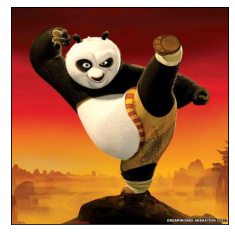

In [18]:
!curl -s https://ichef.bbci.co.uk/news/549/mcs/media/images/77396000/jpg/_77396213_kung-fu-panda-21.jpg --output kunfu_panda.jpg
path = "kunfu_panda.jpg"
plt.imshow(plt.imread(path))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
print(f"It's a {predict(path)}!")

# Thank you